In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
from numba import jit
import pandas as pd
import scipy as sc

# Data

In [3]:
Data = pd.read_csv('initial_masses.dat',delimiter=',')['IMass'].to_numpy()

# Simple Models

In [38]:
def Normalization(alpha,mass):
    C=1-alpha
    C/= np.max(mass)**(1-alpha) - np.min(mass)**(1-alpha)
    return C

def IMF(alpha, mass):
        return Normalization(alpha,mass)*mass**(-alpha)


def prior_gaussian(alpha, sigma_mu, mu=2.35):
    co = 1 / (sigma_mu * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((alpha - mu) / sigma_mu)**2
    return co * np.exp(exponent)

def LogLikelihood(alpha_list, Masses, Prior=False, sigma_mu=0.1):
    LL = np.zeros_like(alpha_list)

    
    if not Prior:
        prior=lambda x: 1/(np.max(alpha_list)-np.min(alpha_list))
        for i in (range(len(alpha_list))):
            I = IMF(alpha_list[i], Masses)
            LL[i] = np.sum(np.log10(I)+np.log10(prior(alpha_list[i])))
    else:
        for i in (range(len(alpha_list))):
            I = IMF(alpha_list[i], Masses)
            prior_value = prior_gaussian(alpha_list[i], sigma_mu=sigma_mu)
            LL[i] = np.sum(np.log10(I * prior_value))

    return LL

def max_log_likelihood(alpha_values, Masses, Prior=False, sigma_mu=0.1):
    LL = LogLikelihood(alpha_values, Masses, Prior=Prior, sigma_mu=sigma_mu)
    max_index = np.argmax(LL)
    Alpha_max = alpha_values[max_index]
    return Alpha_max

def percentile(percentile,alpha_values, Masses, Prior=False, sigma_mu=0.1):
    LL = LogLikelihood(alpha_values, Masses, Prior=Prior, sigma_mu=sigma_mu)
    likelihood = 10**(LL - np.max(LL)) 
    likelihood = likelihood / sc.integrate.trapz(likelihood, alpha_values)
    cdf = sc.integrate.cumtrapz(likelihood, alpha_values, initial=0)
    results = []
    for p in percentile:
        index = np.searchsorted(cdf, p / 100)
        results.append(alpha_values[index] if index < len(alpha_values) else None)

    return results


def plot_log_likelihood(alpha_values,mass,prior=False,log=True,sigma_mu=0.1):
    # Plot the Log Likelihood as a function of Alpha
    fig, ax = plt.subplots(figsize=(10, 7))
    # Plot the log likelihood curve
    alpha_max=max_log_likelihood(alpha_values, mass, Prior=prior,sigma_mu=sigma_mu)
    if log:
        ax.plot(alpha_values, LogLikelihood(alpha_values,mass,Prior=prior,sigma_mu=sigma_mu), label='Log Likelihood', color='blue')
            # Labels and titles
        ax.set_xlabel(r'$\alpha$', fontsize=15)
        ax.set_ylabel(r'Log Likelihood', fontsize=15)
        ax.set_title(r'Log Likelihood vs $\alpha$', fontsize=15)

    else:
        LL=LogLikelihood(alpha_values,mass,Prior=prior,sigma_mu=sigma_mu)
        likelihood = 10**(LL - np.max(LL)) 
        likelihood = likelihood / sc.integrate.trapz(likelihood, alpha_values)
        
        ax.set_xlabel(r'Alpha ($\alpha$)', fontsize=15)
        ax.set_ylabel(r'Posterior ($P({\theta}|\{\mu_i\};M)$)', fontsize=15)
        ax.set_title(r'Posterior of Flat Prior', fontsize=15)
        if prior:
            ax.set_title(r'Posterior with Gaussian Prior $\sigma_\alpha=$'+f'{sigma_mu}', fontsize=15)
        ax.plot(alpha_values, likelihood, label='Normalized Posterior', color='blue')
        percentiles = percentile([15.9, 84.1,50], alpha_values, mass, Prior=prior, sigma_mu=sigma_mu)
        ax.axvline(x=alpha_max, color='red', linestyle='--', label=r'Median at $\alpha$'+f' = {percentiles[-1]:.3f}')
        print(percentiles[1]-percentiles[2])
        print(percentiles[2]-percentiles[0])
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.7)
        ax.text(0.05, 0.95, f'16th percentile: {percentiles[0]:.3f}\n'+f'84th percentile: {percentiles[1]:.3f}', 
            ha='left', va='top', bbox=bbox_props, transform=ax.transAxes)
        ax.fill_between(alpha_values, likelihood, 0, where=((alpha_values >= percentiles[0]) & (alpha_values <= percentiles[1])),
                color='tab:blue', alpha=0.2, label='68% Confidence Interval Region')
        percentiles = percentile([0.01, 99.99], alpha_values, mass, Prior=prior, sigma_mu=sigma_mu)
        ax.set_xlim(percentiles[0],percentiles[1])
    
    ax.set_ylim(0,)
    plt.legend()
# @jit(nopython=True)
def sigma_median(alpha_values,mass,sigma_mu,prior=False):
    alpha_max=max_log_likelihood(alpha_values, mass, Prior=prior, sigma_mu=sigma_mu)
    return alpha_max

Alpha=np.linspace(1.5,2.5,10000)
Alpha=Alpha[Alpha!=1]


## $m_i=\mu_i$

In [5]:
percentile_values = [16, 50, 84]
results = percentile(percentile_values,Alpha,Data,Prior=prior_gaussian,sigma_mu=1)


0.01800180018001818
0.0178017801780177


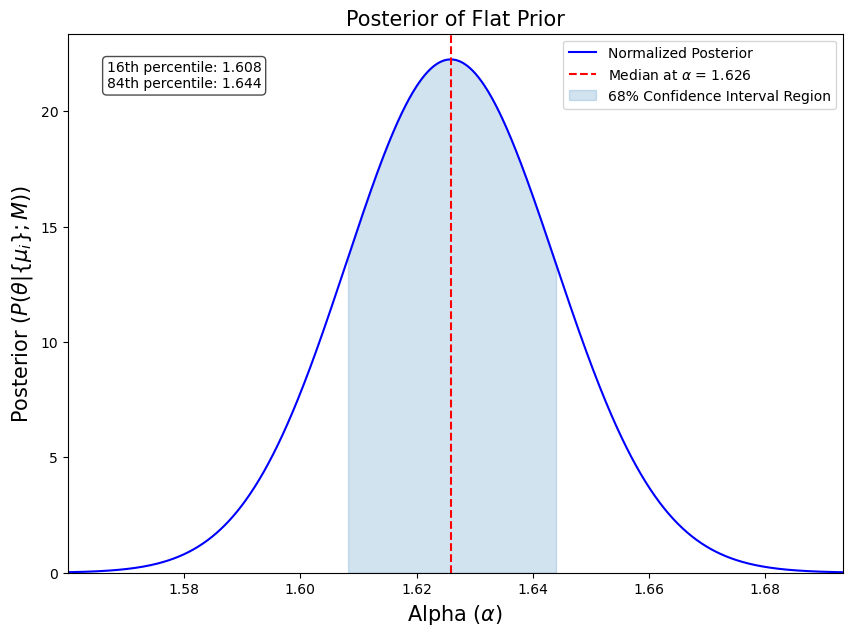

In [33]:
plot_log_likelihood(Alpha,Data,prior=False,log=False)

## Gaussian Prior

0.014301430143014215
0.014201420142014198


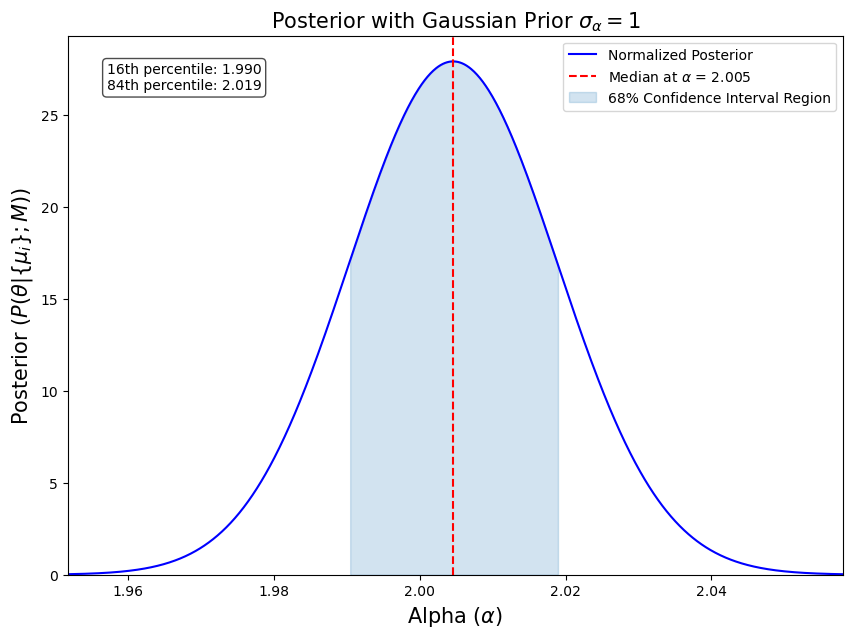

In [39]:
plot_log_likelihood(Alpha,Data,prior=prior_gaussian,log=False,sigma_mu=1)

## Effects of changing the spread of the prior

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1081/1065804168.py:28: RuntimeWarning: divide by zero encountered in log10
  LL[i] = np.sum(np.log10(I * prior_value))
100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


Text(0.5, 1.0, 'Effect of Prior Scatter on the Posterior')

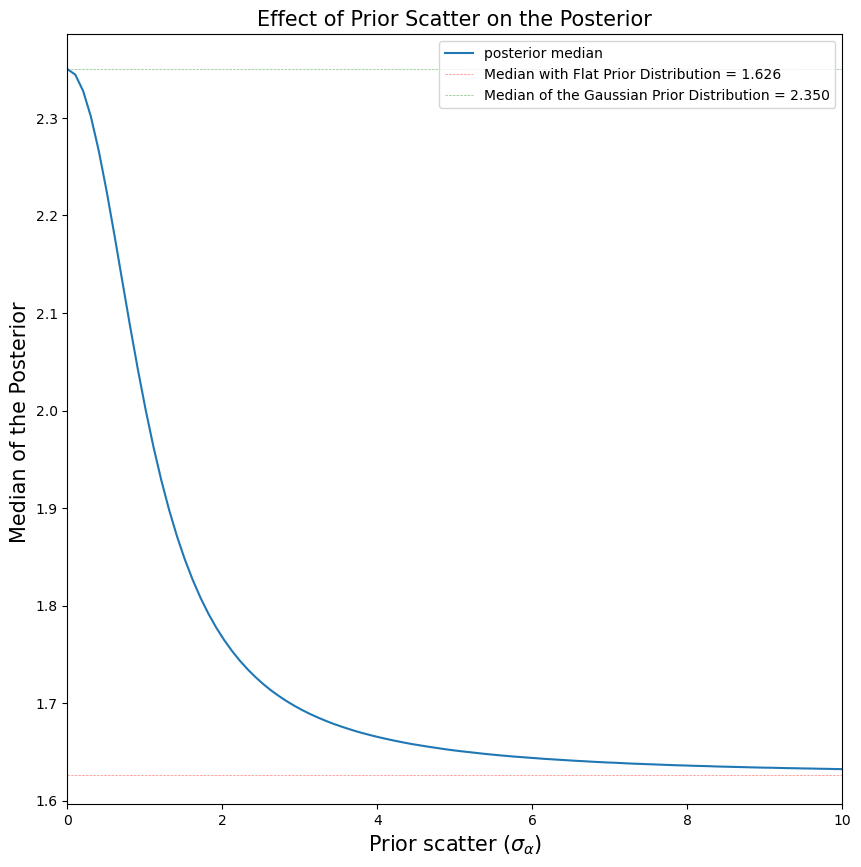

In [37]:
sigma=np.linspace(0.0001,10,100)

mu=[sigma_median(Alpha,Data,prior=prior_gaussian,sigma_mu=sigma[i]) for i in tqdm(range(len(sigma)))]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(sigma,mu, label='posterior median')
ax.set_xlabel(r'Prior scatter $(\sigma_\alpha)$', fontsize=15)
ax.set_ylabel(r'Median of the Posterior ', fontsize=15)
Y_low=percentile([50],Alpha,Data,Prior=False)[0]
Y_high=2.35
ax.axhline(y=Y_low, color='red', linestyle='--', label=r'Median with Flat Prior Distribution'+f' = {Y_low:.3f}',alpha=0.5,lw=0.5)
ax.axhline(y=Y_high, color='green', linestyle='--', label=r'Median of the Gaussian Prior Distribution'+f' = {Y_high:.3f}',alpha=0.5,lw=0.5)
plt.legend(loc='upper right')
ax.set_xlim(0,10)
ax.set_title(r'Effect of Prior Scatter on the Posterior', fontsize=15)

# Extension 1

In [260]:
pd.read_csv('initial_masses.dat',delimiter=',')

,Name,IMass,sigma_IMass
0,Sun,1.000,0.000
1,--HD 224953 A,0.599,0.021
2,--HD 224953 B,0.590,0.085
3,--85 Peg A,0.705,0.060
4,----85 Peg Ba,0.550,0.055
...,...,...,...
2818,--BD+45 4378 B,0.590,0.059
2819,--L 433-153 A,0.200,0.020
2820,--L 433-153 B,0.155,0.016
2821,LP 149-14,0.143,0.004


In [466]:
mu = Data
print(mu)
sigma = pd.read_csv('initial_masses.dat',delimiter=',')['sigma_IMass'].to_numpy()

# @jit(nopython=True)
def P_m_given_sigma_mu(Mu, m_i, sigma_i,alpha):  # sigma is the observed mass uncertainty and M is the observed mass
    gaussian = np.array([1 / (sigma_i * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((m_i - Mu) / sigma_i)**2) for _ in alpha])
    return gaussian

def P_mu_given_alpha(alpha, mu):  # mu is the Real Mass
    return np.array([IMF(alpha, mu) for alpha in alpha])
# @jit(nopython=True)
def Prior(alpha, sigma_mu=0.1, mu=2.35):  # sigma_mu is the prior scatter
    return 1 / (sigma_mu * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((alpha - mu) / sigma_mu)**2) 

def P_mi_given_sigmai_alpha(m_i, sigma_i, alpha):  # Mi is the observed mass, sigmai is the observed mass uncertainty, alpha is a list of alpha values
    integrand = lambda m: P_mu_given_alpha(alpha,mu=m)*P_m_given_sigma_mu(Mu=m, sigma_i=sigma_i, m_i=m_i,alpha=Alpha) #Mu is the integrated mass
    return np.nan_to_num(integrand(mu),nan=0.0)
def P_setmi_given_setsigmai_alpha(alpha, setmi, setsigmai):  # setmi is the observed mass, setsigmai is the observed mass uncertainty
    Integral=(P_mi_given_sigmai_alpha(setmi[i], setsigmai[i], alpha))
    
    return Integral
def posterior(alpha, setmi, setsigmai, sigma_mu=0.1, mu=2.35):
    return P_setmi_given_setsigmai_alpha(alpha, setmi, setsigmai) * Prior(alpha, sigma_mu, mu)

Alpha = np.linspace(1.5, 3, 1000)
Alpha = Alpha[Alpha != 1]

[1.    0.599 0.59  ... 0.155 0.143 0.321]


In [40]:
mu=np.linspace(Data.min()-0.001,Data.max()+0.1,100)
def integrand(alpha_i,m_i,sigma_i):
    return sc.integrate.trapz(IMF(alpha_i,mu)*sc.stats.norm.pdf(mu,loc=m_i,scale=sigma_i),mu)
# def log_likelihood(alpha_i):
#     return np.log10([integrand(alpha_i,Data[i],sigma[i]) for i in range(len(Data))])

def log_likelihood(alpha_i):
    return np.sum(np.log10([sc.integrate.trapz(IMF(alpha_i,mu)*sc.stats.norm.pdf(mu,loc=Data[i],scale=sigma[i]),mu) for i in range(len(Data))]))

def log(A):
    return np.array([log_likelihood(A[a]) for a in tqdm(range(len(A)))])

def adding_prior(a):
    return log(a)+np.log10(Prior(a))

def Posterior_normalized(a):
    P=10**(adding_prior(a)-np.max(adding_prior(a)))
    P=P/sc.integrate.trapz(P,a)
    return P

In [427]:
sc.stats.norm.pdf(mu,loc=Data[0],scale=sigma[0])

array([398.9422804,   0.       ,   0.       , ...,   0.       ,
         0.       ,   0.       ])

In [424]:
data = pd.read_csv('initial_masses.dat',delimiter=',')

sigma = data['sigma_IMass'].to_numpy()

sigma[sigma<=0.0]=np.min(sigma[sigma>0.0])

In [426]:
sigma

array([0.001, 0.021, 0.085, ..., 0.016, 0.004, 0.01 ])

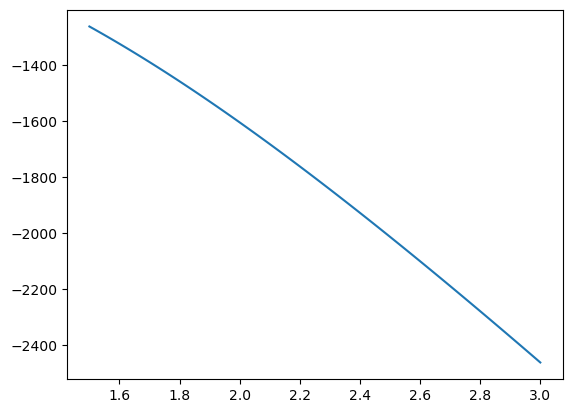

In [326]:
plt.plot(Alpha,)

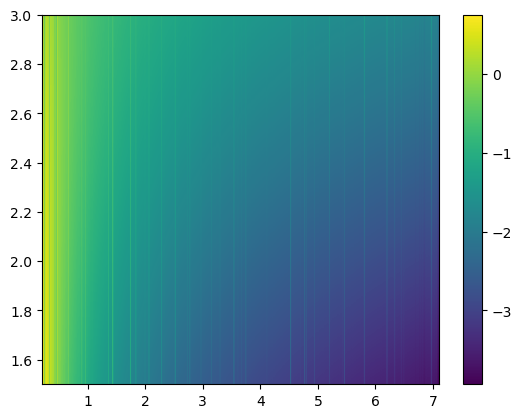

In [327]:
plt.imshow(P, aspect='auto', extent=[mu.min(), mu.max(), Alpha.min(), Alpha.max()])
plt.colorbar()

/tmp/ipykernel_29303/3985103509.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  gaussian = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((M - Mu) / sigma)**2)
/tmp/ipykernel_29303/3985103509.py:5: RuntimeWarning: divide by zero encountered in divide
  gaussian = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((M - Mu) / sigma)**2)
/tmp/ipykernel_29303/3985103509.py:5: RuntimeWarning: invalid value encountered in multiply
  gaussian = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((M - Mu) / sigma)**2)
/tmp/ipykernel_29303/3985103509.py:25: RuntimeWarning: divide by zero encountered in log10
  return P_setmi_given_setsigmai_alpha(alpha, setmi, setsigmai) + np.log10(Prior(alpha, sigma_mu=sigma_mu))


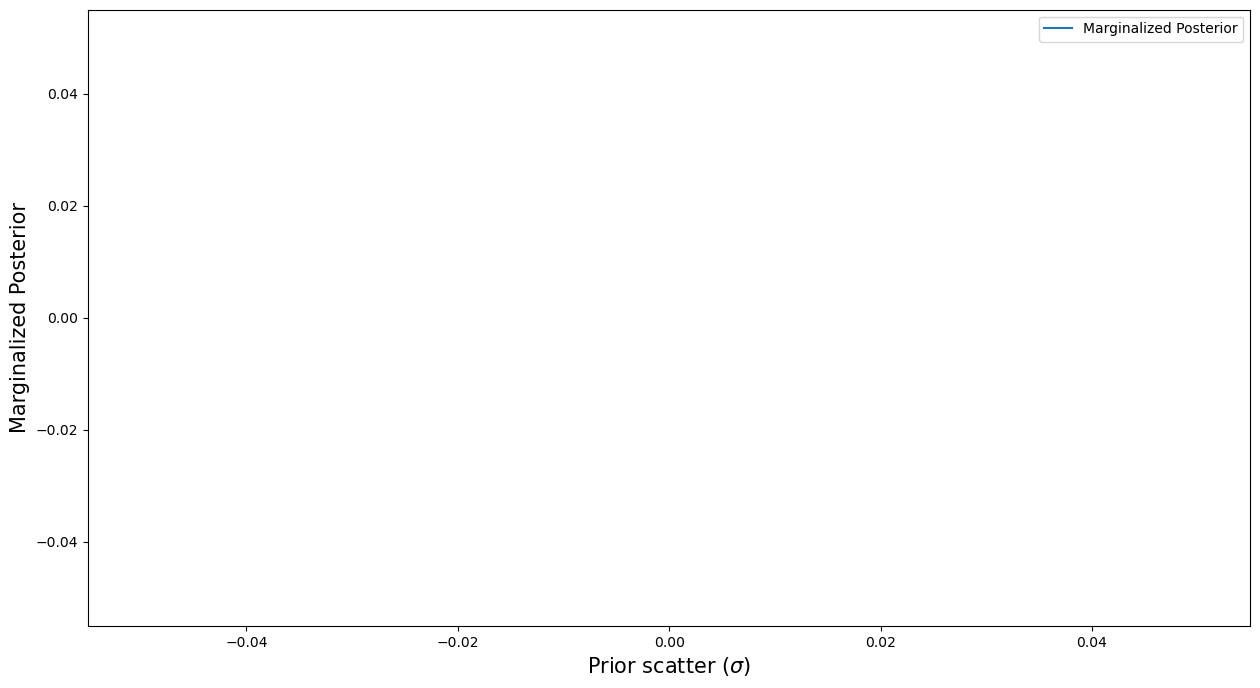

In [266]:
def Marginal_integral(alpha_values, setmi, setsigmai, sigma_mu=0.1):
    posterior = P_alpha_given_setmi_setsigmai_normalized(alpha_values, setmi, setsigmai, sigma_mu=sigma_mu)
    return sc.integrate.trapz(posterior, alpha_values)

def Marginal_integral_sigma(alpha_values, setmi, setsigmai, sigma_mu_values):
    marginal = np.zeros_like(sigma_mu_values)
    for i in range(len(sigma_mu_values)):
        marginal[i] = Marginal_integral(alpha_values, setmi, setsigmai, sigma_mu=sigma_mu_values[i])
    return marginal


sigma_mu_values = np.linspace(0.01, 10, 100)
marginal = Marginal_integral_sigma(alpha_values, Data, sigma, sigma_mu_values)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(sigma_mu_values, marginal, label='Marginalized Posterior')
ax.set_xlabel(r'Prior scatter $(\sigma)$', fontsize=15)
ax.set_ylabel(r'Marginalized Posterior', fontsize=15)
plt.legend()


In [493]:
cdf_values = np.array([ 3.7340889 ,  3.76892519,  3.80739164,  3.8357985 ,  3.85698557,
                        3.87761354,  3.90448165,  3.94876456,  4.00814724,  4.10358858,
                        4.28086233,  4.302279  ,  4.31626749,  4.33082819,  4.34954977,
                        4.38136625,  4.52643251,  4.93673038,  6.69454432,  6.70806074,
                        6.72187281,  6.73224449,  6.73986197,  6.7462635 ,  6.7521162 ,
                        6.75783825,  6.76427031,  6.77200031,  6.78123713,  6.78992367,
                        6.79696131,  6.80287218,  6.808074  ,  6.813169  ,  6.8203969 ,
                       11.69631481, 11.841465  , 11.89101028, 11.9126749 , 11.92359066,
                       11.92905426, 11.93205929, 11.93364716, 11.93445301, 11.93484688,
                       11.93503094, 11.93511391, 11.93515015, 11.93516541, 11.93517113,
                       11.93517399], dtype='>f8')
# cdf_values/= np.max(cdf_values)

# Corresponding z-step values
zstep = np.linspace(0, 10, 51)

# Calculate the discrete derivative (PDF)
pdf_values = np.diff(cdf_values) / np.diff(zstep)

# Optional: append a value to match original array length
pdf_values = np.append(pdf_values, pdf_values[-1])

# Output PDF values
print(pdf_values)

[1.74181450e-01 1.92332250e-01 1.42034300e-01 1.05935350e-01
 1.03139850e-01 1.34340550e-01 2.21414550e-01 2.96913400e-01
 4.77206700e-01 8.86368750e-01 1.07083350e-01 6.99424500e-02
 7.28035000e-02 9.36079000e-02 1.59082400e-01 7.25331300e-01
 2.05148935e+00 8.78906970e+00 6.75821000e-02 6.90603500e-02
 5.18584000e-02 3.80874000e-02 3.20076500e-02 2.92635000e-02
 2.86102500e-02 3.21603000e-02 3.86500000e-02 4.61841000e-02
 4.34327000e-02 3.51882000e-02 2.95543500e-02 2.60091000e-02
 2.54750000e-02 3.61395000e-02 2.43795896e+01 7.25750950e-01
 2.47726400e-01 1.08323100e-01 5.45788000e-02 2.73180000e-02
 1.50251500e-02 7.93935000e-03 4.02925000e-03 1.96935000e-03
 9.20300000e-04 4.14850000e-04 1.81200000e-04 7.63000000e-05
 2.86000000e-05 1.43000000e-05 1.43000000e-05]


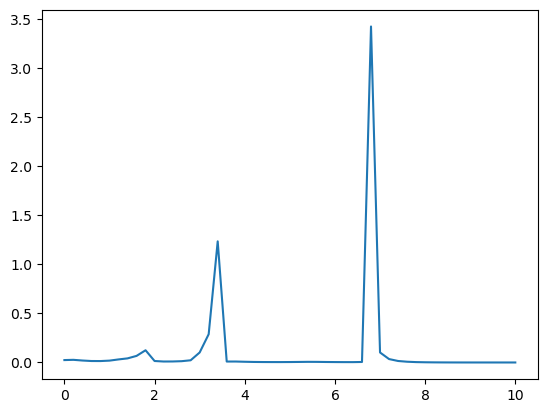

In [492]:
plt.plot(zstep, pdf_values/sc.integrate.simpson(pdf_values,zstep), label='PDF')

pd=pdf_values/sc.integrate.simpson(pdf_values,zstep)


-32.894666239147625

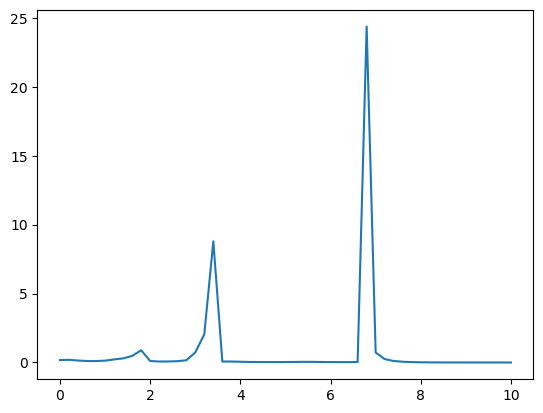